# Sukurkite klasifikavimo modelį: Skanūs Azijos ir Indijos patiekalai


## Virtuvės klasifikatoriai 1

Šioje pamokoje nagrinėsime įvairius klasifikatorius, kad *prognozuotume tam tikrą nacionalinę virtuvę pagal ingredientų grupę.* Tuo pačiu sužinosime daugiau apie tai, kaip algoritmai gali būti naudojami klasifikavimo užduotims.

### [**Prieš paskaitos testas**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Pasiruošimas**

Ši pamoka remiasi mūsų [ankstesne pamoka](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb), kurioje:

-   Švelniai supažindinome su klasifikacijomis, naudodami duomenų rinkinį apie visas nuostabias Azijos ir Indijos virtuves 😋.

-   Išnagrinėjome keletą [dplyr veiksmažodžių](https://dplyr.tidyverse.org/), kad paruoštume ir išvalytume duomenis.

-   Sukūrėme gražias vizualizacijas naudodami ggplot2.

-   Parodėme, kaip spręsti nesubalansuotų duomenų problemą, juos iš anksto apdorojant naudojant [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Parodėme, kaip `prep` ir `bake` mūsų receptą, kad įsitikintume, jog jis veikia taip, kaip numatyta.

#### **Būtinos sąlygos**

Šiai pamokai mums reikės šių paketų, kad galėtume išvalyti, paruošti ir vizualizuoti duomenis:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) yra [R paketų kolekcija](https://www.tidyverse.org/packages), sukurta tam, kad duomenų mokslas būtų greitesnis, lengvesnis ir smagesnis!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) sistema yra [paketų kolekcija](https://www.tidymodels.org/packages/) modeliavimui ir mašininio mokymosi užduotims.

-   `themis`: [themis paketas](https://themis.tidymodels.org/) suteikia papildomus receptų žingsnius nesubalansuotų duomenų tvarkymui.

-   `nnet`: [nnet paketas](https://cran.r-project.org/web/packages/nnet/nnet.pdf) siūlo funkcijas, skirtas vieno paslėpto sluoksnio tiesioginio perdavimo neuroniniams tinklams ir daugianario logistinės regresijos modeliams įvertinti.

Galite juos įdiegti taip:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Arba, žemiau pateiktas scenarijus patikrina, ar turite moduliui užbaigti reikalingus paketus, ir, jei jų trūksta, įdiegia juos už jus.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Padalinkite duomenis į mokymo ir testavimo rinkinius.

Pradėsime pasirinkdami kelis žingsnius iš ankstesnės pamokos.

### Pašalinkite dažniausiai pasitaikančius ingredientus, kurie sukelia painiavą tarp skirtingų virtuvių, naudodami `dplyr::select()`.

Visi mėgsta ryžius, česnaką ir imbierą!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Puiku! Dabar laikas padalyti duomenis taip, kad 70% duomenų būtų skirta mokymui, o 30% – testavimui. Taip pat pritaikysime `stratifikacijos` techniką, kad `išlaikytume kiekvienos virtuvės proporcijas` mokymo ir validacijos rinkiniuose.

[rsample](https://rsample.tidymodels.org/), Tidymodels paketas, suteikia infrastruktūrą efektyviam duomenų skirstymui ir resamplingui:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Spręsti duomenų disbalansą

Kaip galėjote pastebėti pradiniame duomenų rinkinyje, taip pat ir mūsų mokymo rinkinyje, yra gana nelygiavertis virtuvių skaičiaus pasiskirstymas. Korėjiečių virtuvės yra *beveik* 3 kartus daugiau nei tailandiečių virtuvės. Duomenų disbalansas dažnai neigiamai veikia modelio našumą. Daugelis modelių geriausiai veikia, kai stebėjimų skaičius yra vienodas, todėl jiems dažnai sunku dirbti su nesubalansuotais duomenimis.

Yra du pagrindiniai būdai spręsti nesubalansuotų duomenų rinkinius:

-   pridėti stebėjimų prie mažumos klasės: `Per-sampling` (pvz., naudojant SMOTE algoritmą, kuris sintetiškai generuoja naujus mažumos klasės pavyzdžius, remdamasis artimiausiais kaimynais).

-   pašalinti stebėjimus iš daugumos klasės: `Under-sampling`

Ankstesnėje pamokoje parodėme, kaip spręsti nesubalansuotų duomenų rinkinius naudojant `recipe`. Receptą galima laikyti planu, kuris aprašo, kokius veiksmus reikia taikyti duomenų rinkiniui, kad jis būtų paruoštas duomenų analizei. Mūsų atveju, norime užtikrinti vienodą virtuvių pasiskirstymą mūsų `mokymo rinkinyje`. Pradėkime!


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Galite, žinoma, patvirtinti (naudodami prep+bake), kad receptas veikia taip, kaip tikitės - visi virtuvės etiketės turi „559“ stebėjimus.

Kadangi šį receptą naudosime kaip išankstinį apdorojimą modeliavimui, `workflow()` atliks visą paruošimą ir kepimą už mus, todėl nereikės rankiniu būdu įvertinti recepto.

Dabar esame pasiruošę treniruoti modelį 👩‍💻👨‍💻!

## 3. Klasifikatoriaus pasirinkimas

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Piešinys @allison_horst</figcaption>


Dabar turime nuspręsti, kurį algoritmą naudoti šiam darbui 🤔.

Tidymodels pakete [`parsnip package`](https://parsnip.tidymodels.org/index.html) pateikiama nuosekli sąsaja darbui su modeliais, naudojant skirtingus variklius (paketus). Peržiūrėkite parsnip dokumentaciją, kad susipažintumėte su [modelių tipais ir varikliais](https://www.tidymodels.org/find/parsnip/#models) bei jų atitinkamais [modelių argumentais](https://www.tidymodels.org/find/parsnip/#model-args). Įvairovė iš pradžių gali atrodyti stulbinanti. Pavyzdžiui, šie metodai apima klasifikavimo technikas:

-   C5.0 taisyklėmis pagrįsti klasifikavimo modeliai

-   Lankstūs diskriminantų modeliai

-   Linijiniai diskriminantų modeliai

-   Reguliarizuoti diskriminantų modeliai

-   Logistinės regresijos modeliai

-   Daugianarės regresijos modeliai

-   Naivūs Bayes modeliai

-   Atraminių vektorių mašinos

-   Artimiausių kaimynų metodas

-   Sprendimų medžiai

-   Ansamblio metodai

-   Neuroniniai tinklai

Sąrašas tęsiasi!

### **Kokį klasifikatorių pasirinkti?**

Taigi, kurį klasifikatorių reikėtų rinktis? Dažnai geriausias būdas yra išbandyti kelis ir ieškoti gero rezultato.

> AutoML puikiai išsprendžia šią problemą, atlikdamas palyginimus debesyje ir leisdamas pasirinkti geriausią algoritmą jūsų duomenims. Išbandykite [čia](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Be to, klasifikatoriaus pasirinkimas priklauso nuo mūsų problemos. Pavyzdžiui, kai rezultatas gali būti suskirstytas į `daugiau nei dvi klases`, kaip mūsų atveju, turite naudoti `daugianarės klasifikacijos algoritmą`, o ne `dvejetainę klasifikaciją.`

### **Geresnis požiūris**

Tačiau geresnis būdas nei spėliojimas yra vadovautis idėjomis iš šio atsisiunčiamo [ML Cheat sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Čia sužinome, kad mūsų daugianarės klasifikacijos problemai turime keletą pasirinkimų:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Microsoft algoritmų apgaulės lapo dalis, apibūdinanti daugianarės klasifikacijos galimybes</figcaption>


### **Samprotavimas**

Pažiūrėkime, ar galime logiškai apsvarstyti skirtingus požiūrius, atsižvelgdami į turimus apribojimus:

-   **Gilūs neuroniniai tinklai yra per sudėtingi**. Atsižvelgiant į mūsų švarų, bet minimalų duomenų rinkinį ir tai, kad mokymą vykdome lokaliai per užrašų knygeles, gilūs neuroniniai tinklai yra per sudėtingi šiai užduočiai.

-   **Dviejų klasių klasifikatorius netinka**. Mes nenaudojame dviejų klasių klasifikatoriaus, todėl vienos prieš visas metodas netinka.

-   **Sprendimų medis arba logistinė regresija galėtų veikti**. Sprendimų medis galėtų būti tinkamas, arba daugialypė regresija/daugialypė logistinė regresija, skirta daugiaklasiams duomenims.

-   **Daugiaklasiai sustiprinti sprendimų medžiai sprendžia kitokią problemą**. Daugiaklasiai sustiprinti sprendimų medžiai labiausiai tinka neparametrinėms užduotims, pvz., užduotims, skirtoms reitingų sudarymui, todėl jie mums nėra naudingi.

Be to, paprastai prieš pradedant naudoti sudėtingesnius mašininio mokymosi modelius, pvz., ansamblio metodus, verta sukurti kuo paprastesnį modelį, kad suprastume, kas vyksta. Todėl šioje pamokoje pradėsime nuo `daugialypės regresijos` modelio.

> Logistinė regresija yra technika, naudojama, kai rezultato kintamasis yra kategorinis (arba nominalus). Dvejetainėje logistinėje regresijoje rezultatų kintamųjų skaičius yra du, o daugialypėje logistinėje regresijoje rezultatų kintamųjų skaičius yra daugiau nei du. Daugiau informacijos rasite [Pažangūs regresijos metodai](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html).

## 4. Mokykite ir įvertinkite daugialypės logistinės regresijos modelį.

Naudojant Tidymodels, `parsnip::multinom_reg()` apibrėžia modelį, kuris naudoja linijinius prognozatorius, kad prognozuotų daugiaklasius duomenis, remdamasis daugialype skirstinio funkcija. Žr. `?multinom_reg()` dėl skirtingų būdų/variklių, kuriuos galite naudoti šiam modeliui pritaikyti.

Šiame pavyzdyje pritaikysime daugialypės regresijos modelį naudodami numatytąjį [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) variklį.

> Atsitiktinai pasirinkau `penalty` reikšmę. Yra geresnių būdų pasirinkti šią reikšmę, pavyzdžiui, naudojant `resampling` ir `modelio derinimą`, apie kuriuos kalbėsime vėliau.
>
> Žr. [Tidymodels: Pradėkite](https://www.tidymodels.org/start/tuning/), jei norite sužinoti daugiau apie modelio hiperparametrų derinimą.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Puikus darbas 🥳! Dabar, kai turime receptą ir modelio specifikaciją, turime rasti būdą, kaip juos sujungti į objektą, kuris pirmiausia apdoros duomenis, tada pritaikys modelį apdorotiems duomenims ir taip pat leis atlikti galimas poapdorojimo veiklas. Tidymodels bibliotekoje šis patogus objektas vadinamas [`workflow`](https://workflows.tidymodels.org/) ir patogiai talpina jūsų modeliavimo komponentus! Tai, ką Python'e vadintume *pipelines*.

Taigi, sujunkime viską į workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Darbo eigos 👌👌! **`workflow()`** gali būti pritaikyta panašiai kaip ir modelis. Taigi, laikas treniruoti modelį!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Modelio mokymo metu gauti koeficientai.

### Įvertinkite apmokytą modelį

Atėjo metas patikrinti, kaip modelis pasirodė 📏, įvertinant jį su testiniu rinkiniu! Pradėkime nuo prognozių sudarymo testiniame rinkinyje.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Puikus darbas! Tidymodels aplinkoje modelio veikimas gali būti vertinamas naudojant [yardstick](https://yardstick.tidymodels.org/) - paketą, skirtą modelių efektyvumui matuoti naudojant veikimo metrikas. Kaip darėme logistinės regresijos pamokoje, pradėkime nuo painiavos matricos skaičiavimo.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Kai dirbama su keliomis klasėmis, paprastai yra intuityviau tai vizualizuoti kaip šilumos žemėlapį, štai taip:


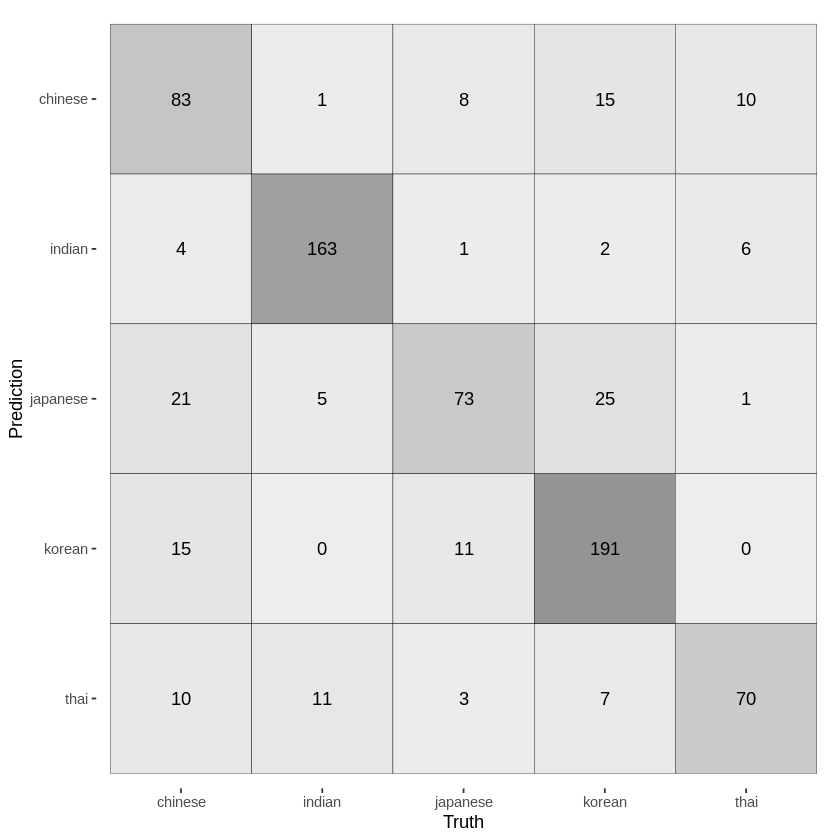

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Tamsesni kvadratai painiavos matricos grafike rodo didelį atvejų skaičių, ir tikimės, kad matote įstrižą liniją iš tamsesnių kvadratų, kurie nurodo atvejus, kai prognozuota ir faktinė etiketė sutampa.

Dabar apskaičiuokime painiavos matricos apibendrinančią statistiką.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Jei apsiribosime tam tikrais rodikliais, tokiais kaip tikslumas, jautrumas, ppv, pradžiai visai neblogai 🥳!

## 4. Gilinamės

Paklauskime subtilaus klausimo: kokiais kriterijais remiantis pasirenkama tam tikra virtuvės rūšis kaip numatytas rezultatas?

Na, statistiniai mašininio mokymosi algoritmai, tokie kaip logistinė regresija, yra pagrįsti `tikimybe`; taigi, ką iš tikrųjų prognozuoja klasifikatorius, yra tikimybių pasiskirstymas tarp galimų rezultatų rinkinio. Klasė, turinti didžiausią tikimybę, tada pasirenkama kaip labiausiai tikėtinas rezultatas pagal pateiktus stebėjimus.

Pažiūrėkime, kaip tai veikia praktiškai, atlikdami tiek griežtas klasių prognozes, tiek tikimybių skaičiavimus.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

Daug geriau!

✅ Ar galite paaiškinti, kodėl modelis yra gana tikras, kad pirmasis stebėjimas yra tailandietiškas?

## **🚀Iššūkis**

Šioje pamokoje jūs naudojote išvalytus duomenis, kad sukurtumėte mašininio mokymosi modelį, galintį prognozuoti nacionalinę virtuvę pagal ingredientų sąrašą. Skirkite šiek tiek laiko peržiūrėti [daugybę parinkčių](https://www.tidymodels.org/find/parsnip/#models), kurias Tidymodels siūlo duomenų klasifikavimui, ir [kitus būdus](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models), kaip pritaikyti daugianarę regresiją.

#### AČIŪ:

[`Allison Horst`](https://twitter.com/allison_horst/) už nuostabias iliustracijas, kurios padaro R labiau prieinamą ir įdomų. Daugiau iliustracijų rasite jos [galerijoje](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) ir [Jen Looper](https://www.twitter.com/jenlooper) už originalios šio modulio Python versijos sukūrimą ♥️

<br>
Būčiau pridėjęs keletą juokelių, bet nesuprantu maisto kalambūrų 😅.

<br>

Sėkmingo mokymosi,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambasadorius.



---

**Atsakomybės apribojimas**:  
Šis dokumentas buvo išverstas naudojant AI vertimo paslaugą [Co-op Translator](https://github.com/Azure/co-op-translator). Nors siekiame tikslumo, prašome atkreipti dėmesį, kad automatiniai vertimai gali turėti klaidų ar netikslumų. Originalus dokumentas jo gimtąja kalba turėtų būti laikomas autoritetingu šaltiniu. Kritinei informacijai rekomenduojama profesionali žmogaus vertimo paslauga. Mes neprisiimame atsakomybės už nesusipratimus ar klaidingus interpretavimus, atsiradusius naudojant šį vertimą.
